# *Time Series Analysis* untuk Harga Beras di Jawa Tengah 2017-2023
---
## Contents:  
1.  Data Analysis
    * Plot Data
2.  Decomposition
3.  Stationarity
    * Statistical Test
    * Differencing: 1st Order
4.  Autocorrelation Function
    * Differencing: 2nd Order
5.  Modeling
    * Prediction

In [120]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Data Analysis

In [121]:
# Load dataset & store as dataframe variable
df = pd.read_excel(io='comodity rice.xlsx')
df

FileNotFoundError: [Errno 2] No such file or directory: 'comodity rice.xlsx'

In [ ]:
# Display dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Tanggal            2525 non-null   datetime64[ns]
 1   Prov. Jawa Tengah  2525 non-null   float64       
 2   Kota Semarang      2525 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 59.3 KB


Informasi mengenai data:
* Harga beras harian di Kota Semarang & Provinsi Jawa Tengah dalam kurun waktu Februari 2017 - Desember 2023.
* Satuannya dalam Rupiah, & terdapat 2525 observasi.

In [ ]:
# 1. Drop unused column
# 2. Convert frequency to monthly average
# 3. Round up to nearest integer & reset index
df = df.drop(columns='Kota Semarang')\
    .resample(rule='M', on='Tanggal').mean()\
        .round().reset_index()

# Convert data type to integer & rename columns
df['Prov. Jawa Tengah'] = df['Prov. Jawa Tengah'].astype(dtype=int)
df.rename(columns={'Prov. Jawa Tengah': 'Harga'}, inplace=True)

# Re-set index & drop unused column
df.index = df['Tanggal']
df.drop(columns='Tanggal', inplace=True)
df

,Harga
Tanggal,
2017-02-28,9781
2017-03-31,9681
2017-04-30,9751
2017-05-31,9907
2017-06-30,10012
...,...
2023-08-31,12858
2023-09-30,13869
2023-10-31,14180


### Plot Data

c:\Users\Garudapaksi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Garudapaksi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


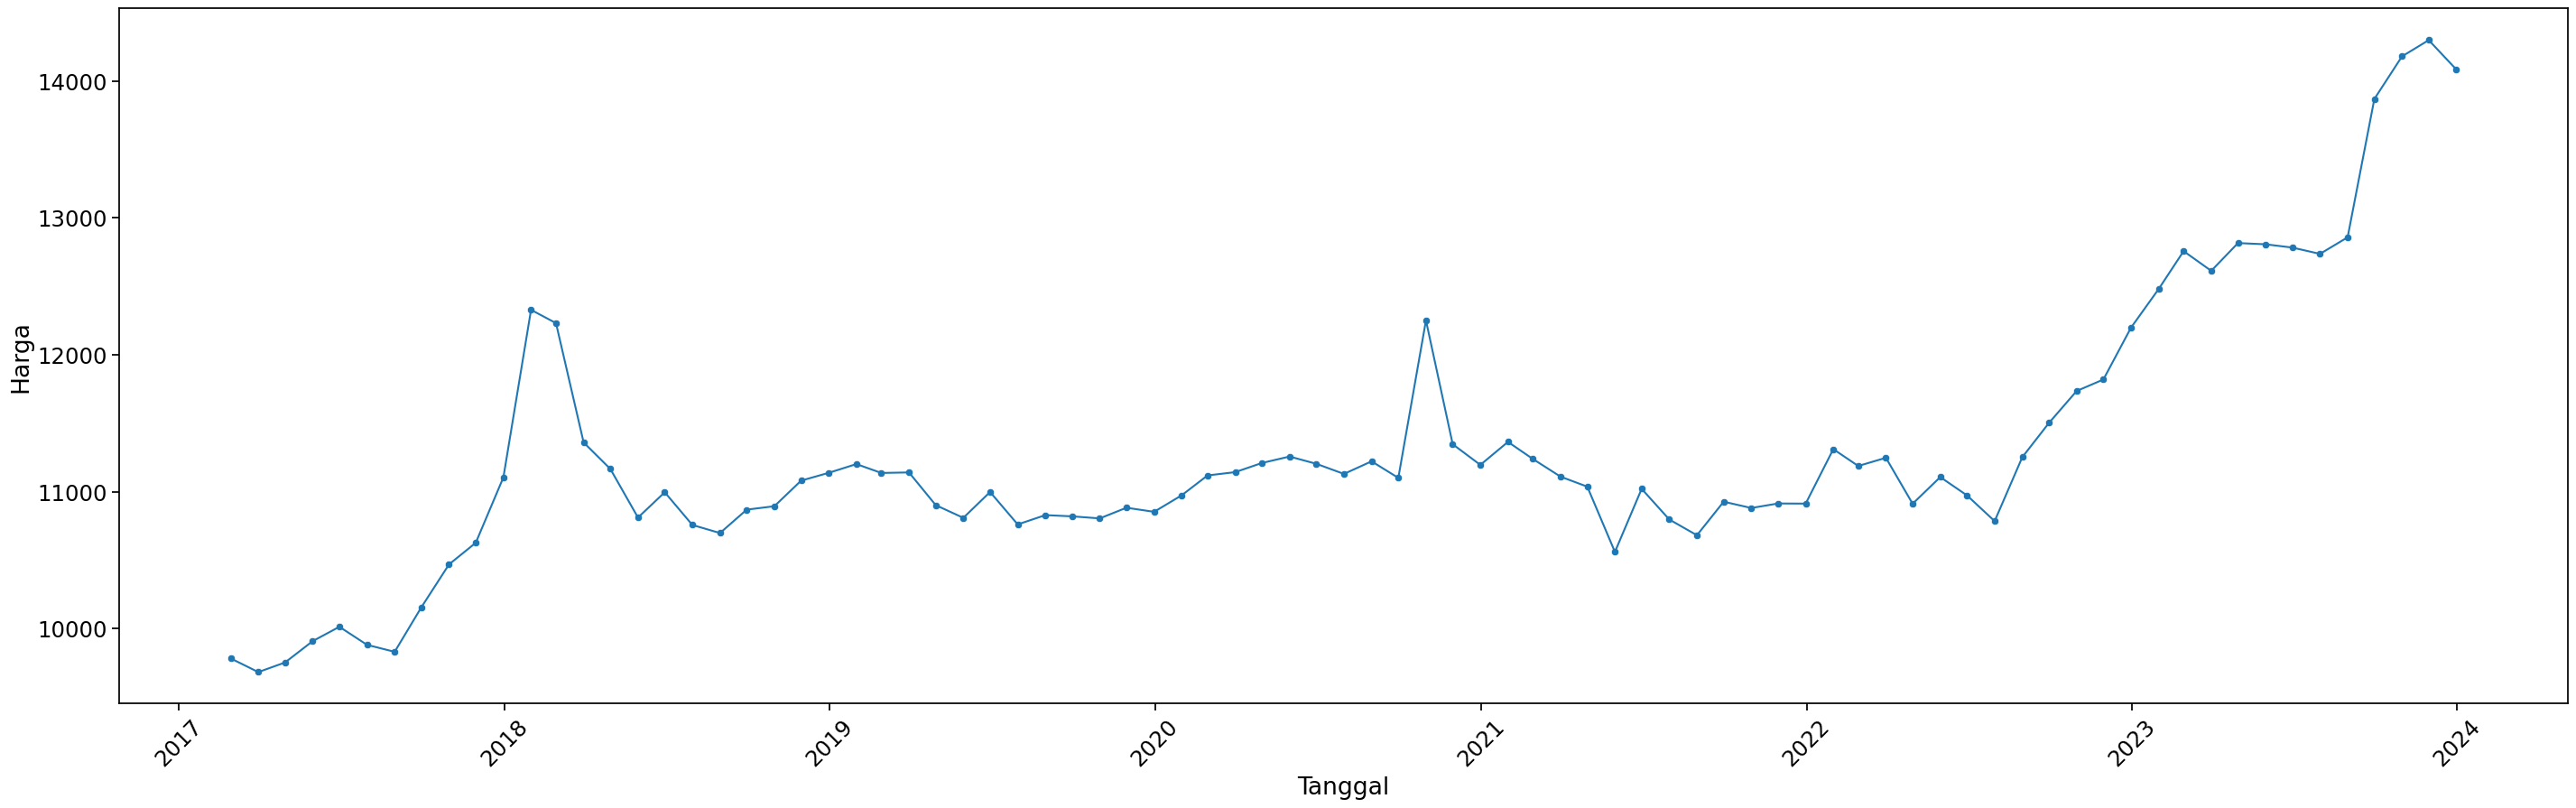

In [ ]:
# Set the image size
plt.figure(figsize = (35, 10))

# Create a line plot from the original data
sns.set_context(context='notebook', font_scale=1.6)
sns.scatterplot(x='Tanggal' , y='Harga', data=df)
sns.lineplot(x='Tanggal', y='Harga', data=df)
plt.xticks(rotation=45)

# Show graph
plt.show()

Harga beras di Provinsi Jawa Tengah memiliki tren yang meningkat dan diduga sifatnya musiman (*seasonal*) pada periode tertentu (meningkat di awal/akhir tahun).

---
## Decomposition

Dekomposisi data menggunakan model *additive* karena sifat dari kenaikan tren/*seasonality* harga beras tersebut cenderung konstan (tidak *multiplicative*).

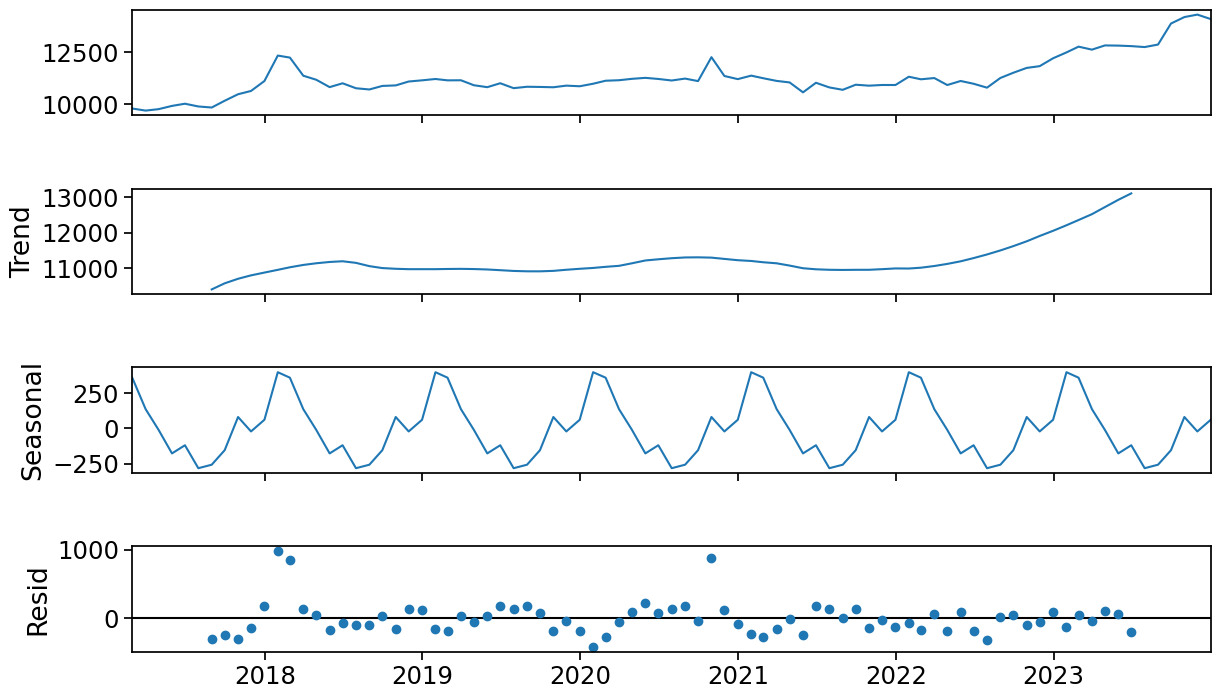

In [ ]:
# Decompose data & plot the result
decomposition = seasonal_decompose(x=df, model='additive')
fig = decomposition.plot()
fig.set_size_inches(15, 8)

Informasi mengenai hasil dekomposisi:
1. Tren secara keseluruhan naik, namun ada stagnasi antara pertengahan 2018 hingga 2022.
2. Ada aspek musiman kurang lebih setiap 12 bulan.
3. Jika kita gunakan model linear pada data *time series* ini, nilai kesalahan prediksinya (*residual*) mendekati 0. Namun ada beberapa fluktuasi yang muncul setiap 2 tahun sekali.

---
## *Stationarity*

### Statistical Test

Dari grafik tersebut juga bisa dikatakan rata-rata harga sifatnya tidak stasioner; baik tiap bulan maupun tiap tahun selalu berubah nilainya.  
Untuk menyatakan apakah nilai ini telah bersifat *stationary* atau tidak, dapat menggunakan uji statistik *Augmented Dickey-Fuller* (ADF).

In [ ]:
# Define a function to perform the Dickey-Fuller test
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
# Check stationarity of data
check_stationarity(df['Harga'])

ADF Statistic: 0.320808
p-value: 0.978279
Critical Values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
Non-stationary


*p-value* > 0.05 (5%), sehingga dinyatakan bahwa kita tidak dapat menolak H0 (data memiliki *unit root* dan sifatnya non-stasioner).  
Semakin negatif nilai statistiknya, data semakin stasioner; ditambah dengan nilai signifikansinya (probabilitas H0 diterima).

### Differencing: 1st Order

c:\Users\Garudapaksi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Garudapaksi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


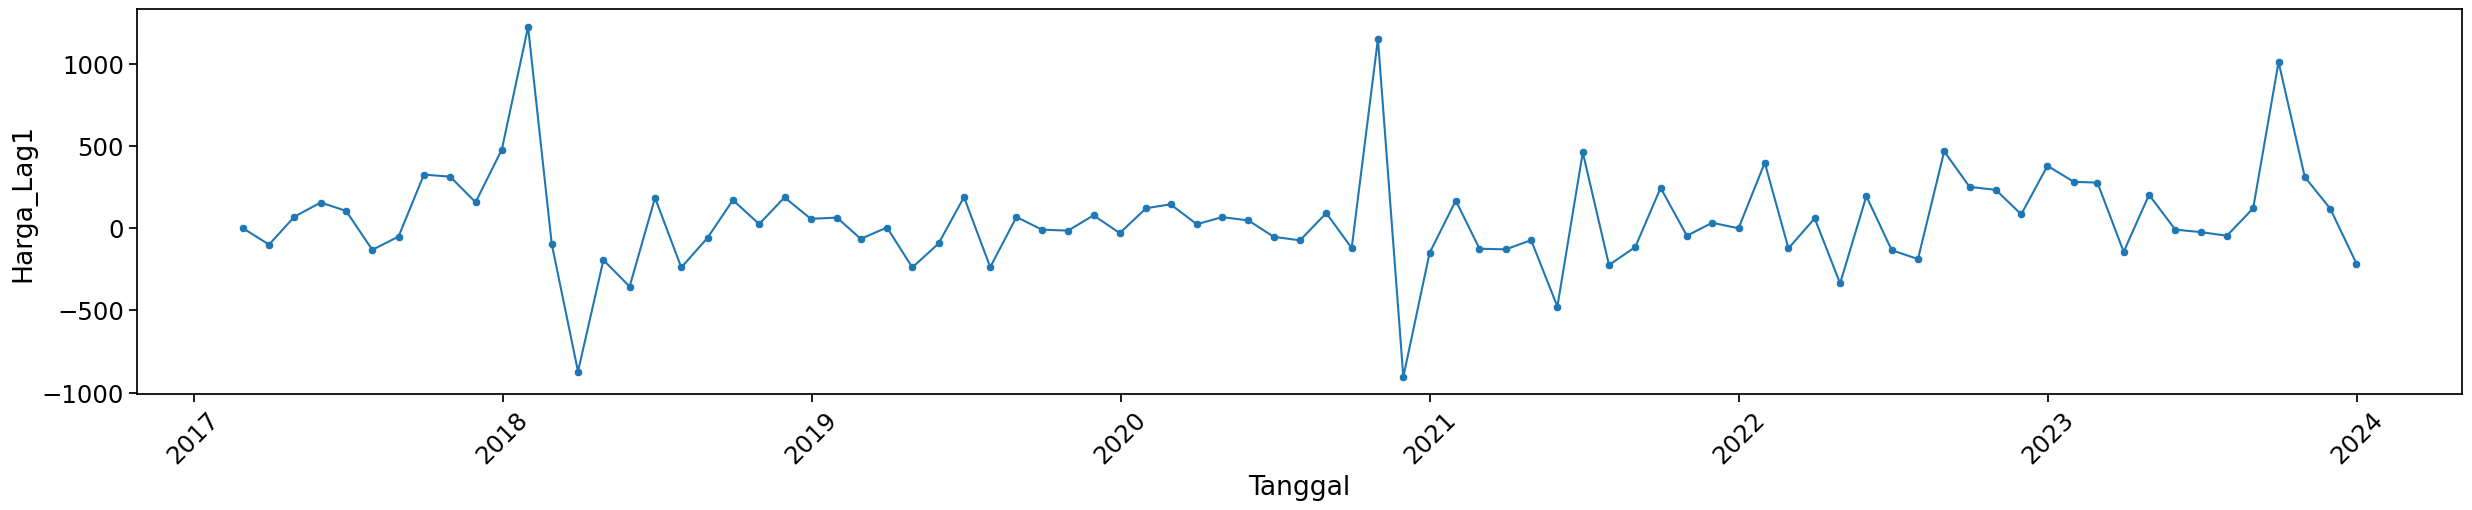

In [ ]:
# Experiment first order difference to make stationary
df['Harga_Lag1'] = df['Harga'].diff(periods=1)
df = df.fillna(0)

# Set the image size
plt.figure(figsize = (30, 5))

# Create a line plot after first-order difference
sns.set_context(context = 'notebook', font_scale=1.6)
sns.scatterplot(x = 'Tanggal' , y = 'Harga_Lag1', data = df)
sns.lineplot(x = 'Tanggal', y = 'Harga_Lag1', data = df)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Check stationarity of data
check_stationarity(df['Harga_Lag1'])

ADF Statistic: -9.107260
p-value: 0.000000
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586
Stationary


---
## Autocorrelation Function

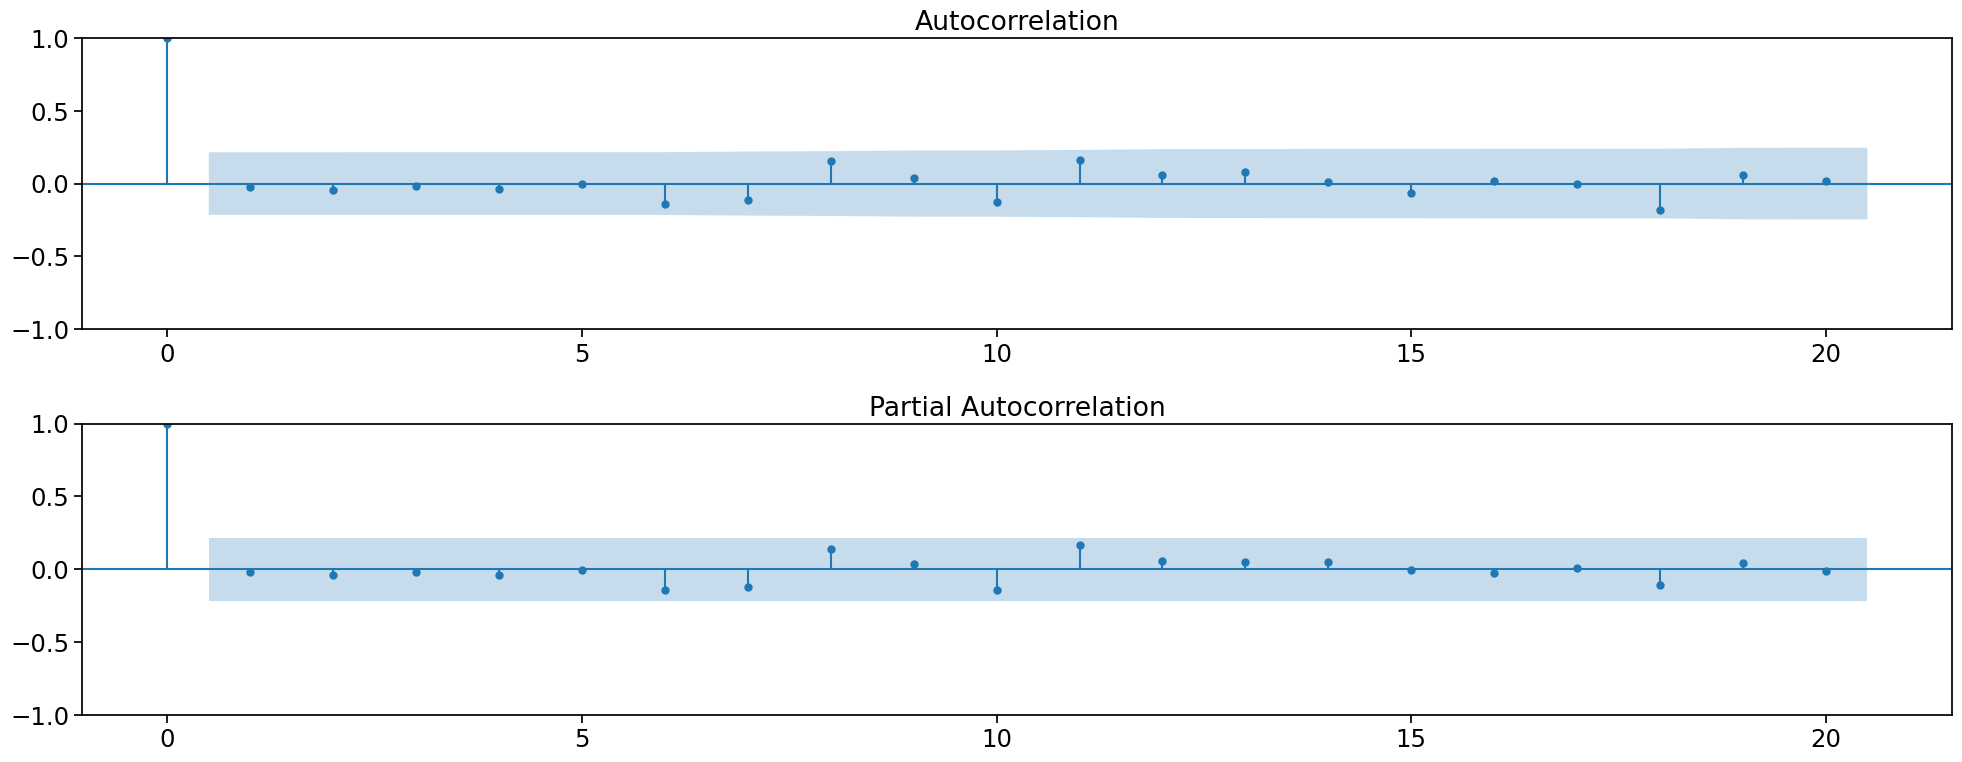

In [ ]:
# Create subplots and resize the graph
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))

# Create ACF and PACF plot
plot_acf(df['Harga_Lag1'], ax=ax[0])
plot_pacf(df['Harga_Lag1'], ax=ax[1])

# Show graph
plt.tight_layout()
plt.show()

* Rata-rata korelasi antara harga beras dengan harga lag-1 mendekati 0
* *Variance* dari rerata tersebut konstan (area biru berukuran konstan)
* *Autocorrelation* signifikan di lag-0 = *time series* ini sifatnya acak dan hanya menjadi *white noise* (tidak bisa diprediksikan)

### Differencing: 2nd Order

c:\Users\Garudapaksi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Garudapaksi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


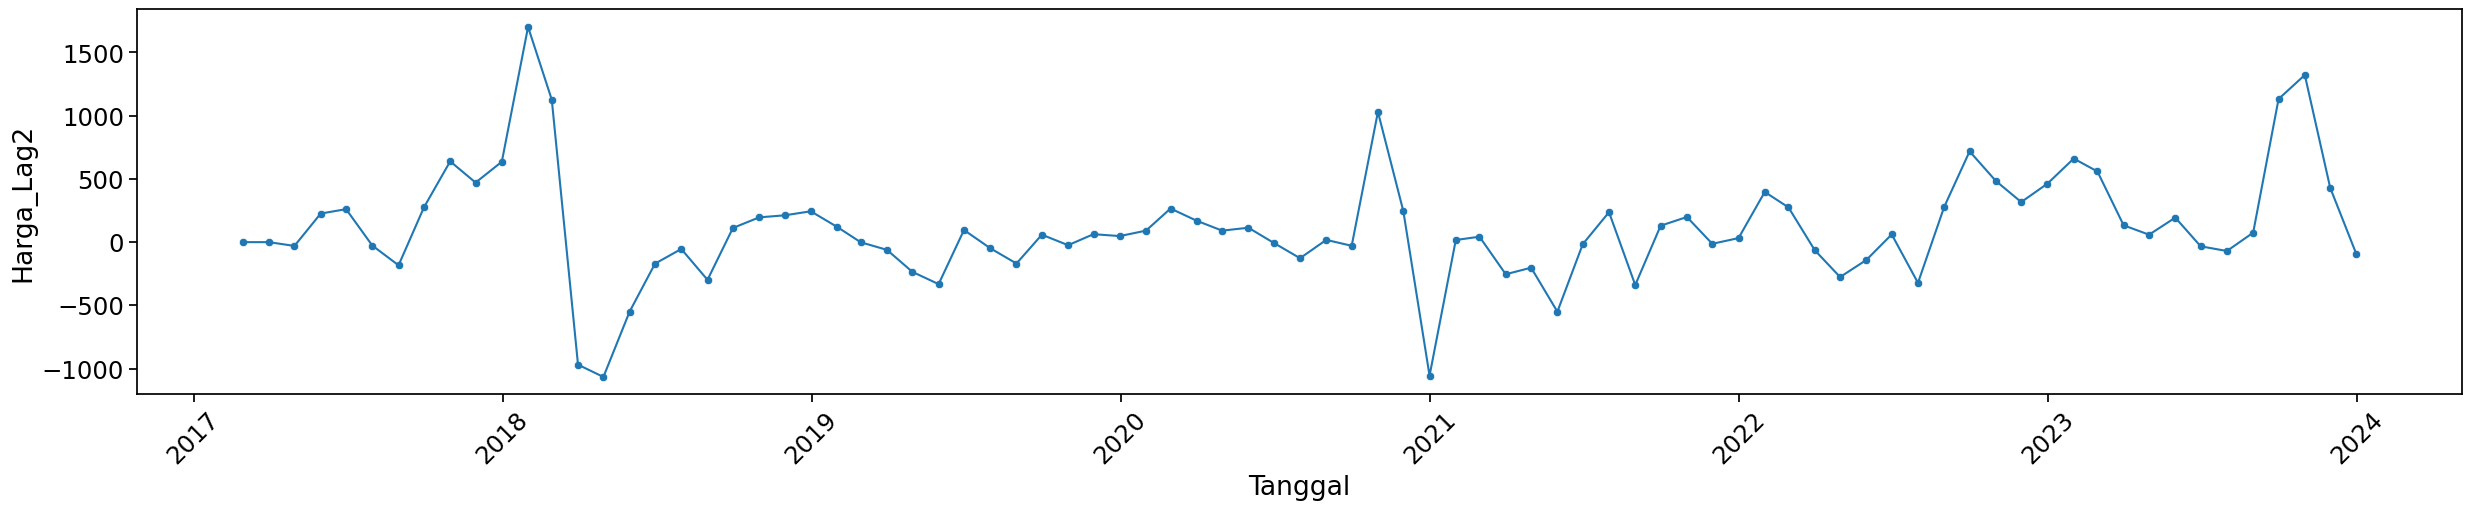

In [ ]:
# Experiment second order difference
df['Harga_Lag2'] = df['Harga'].diff(2)
df = df.fillna(0)

# Set the image size
plt.figure(figsize = (30, 5))

# Create a line plot after first-order difference
sns.set_context(context = 'notebook', font_scale=1.6)
sns.scatterplot(x = 'Tanggal' , y = 'Harga_Lag2', data = df)
sns.lineplot(x = 'Tanggal', y = 'Harga_Lag2', data = df)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Check stationarity of data
check_stationarity(df['Harga_Lag2'])

ADF Statistic: -3.039641
p-value: 0.031355
Critical Values:
	1%: -3.519
	5%: -2.900
	10%: -2.587
Stationary


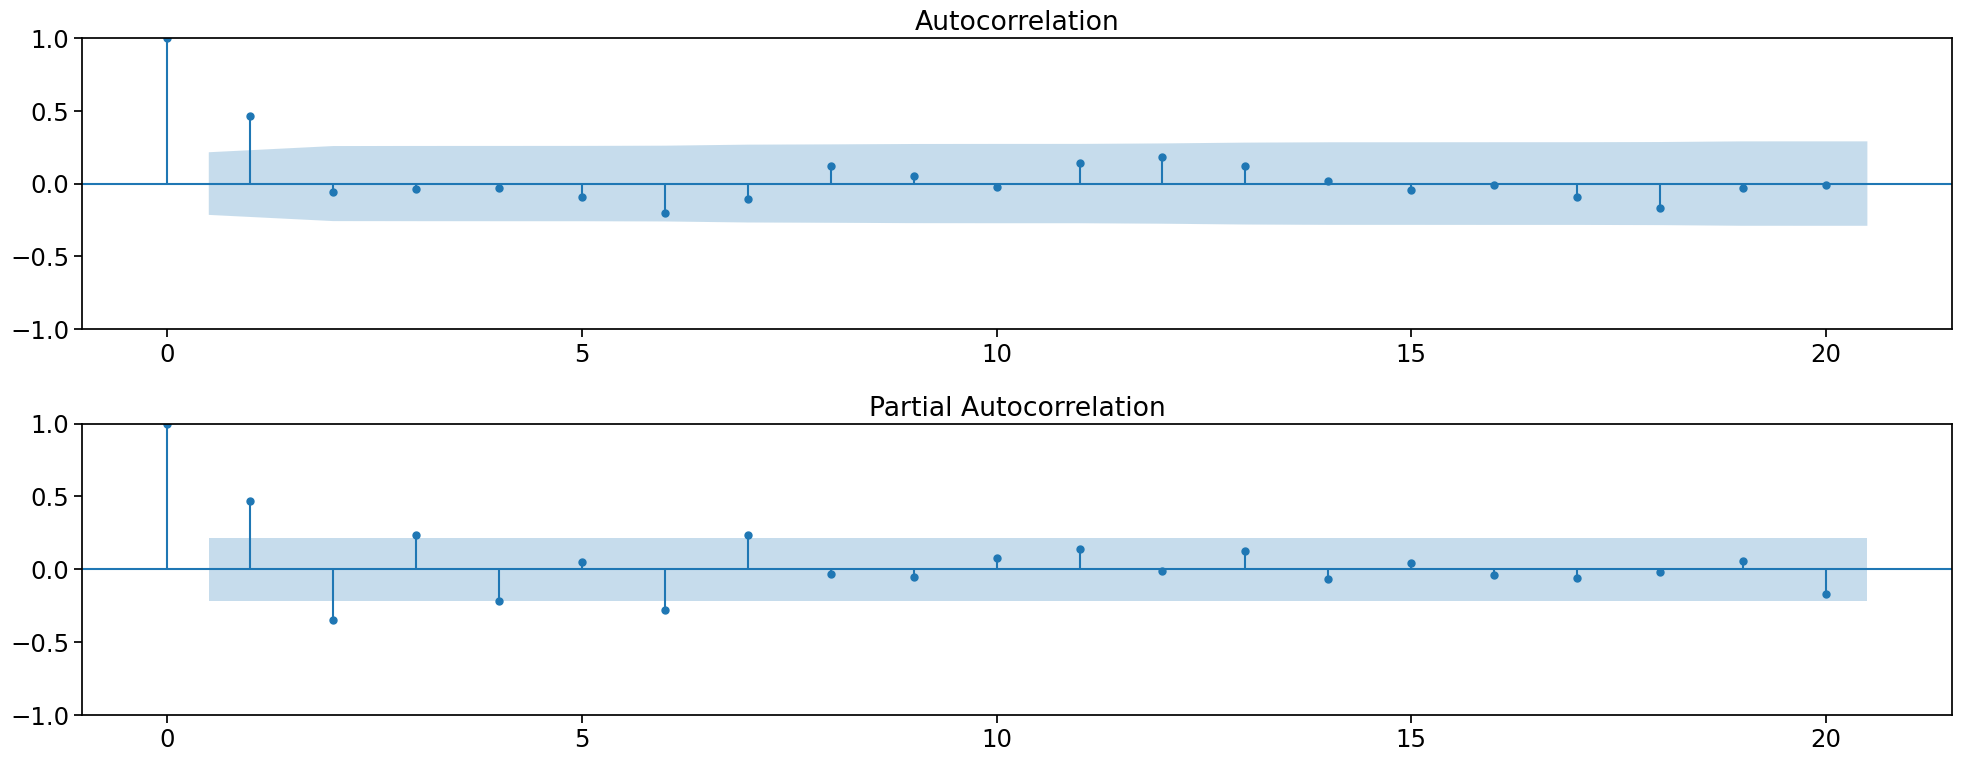

In [ ]:
# Create subplots and resize the graph
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))

# Create ACF and PACF plot
plot_acf(df['Harga_Lag2'], ax=ax[0])
plot_pacf(df['Harga_Lag2'], ax=ax[1])

# Show graph
plt.tight_layout()
plt.show()

* ACF *cut off* lag 1 (q = 1)
* PACF *tails off* (*geometric decay*)

ARIMA order: MA(1) + *second-order differencing* (d = 2)

## Modeling

In [ ]:
# Fit the ARIMA model with the determined order (p, d, q)
model = ARIMA(endog=df['Harga'], order=(0, 2, 1), freq='M')
model = model.fit()

# Get a summary of the ARIMA model
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Harga   No. Observations:                   83
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -586.019
Date:                Wed, 29 May 2024   AIC                           1176.038
Time:                        21:10:23   BIC                           1180.827
Sample:                    02-28-2017   HQIC                          1177.960
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9980      0.703     -1.419      0.156      -2.376       0.380
sigma2      9.607e+04    6.7e+04      1.433      0.152   -3.53e+04    2.27e+05
Ljung-Box (L1) (Q):                   0.00   Jarque-

c:\Users\Garudapaksi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Persyaratan utama dalam model ARIMA adalah sifat stasioner dalam data, yang ditunjukkan melalui:
1. Rata-rata dari data bukan merupakan fungsi dari waktu (tidak berubah seiring berjalannya waktu), dan
2. *Variance* dari *time series* juga bukan merupakan fungsi dari waktu

Uji statistik terhadap *heteroskedasticity*:  
H0: > 5% = *homoskedastic*; distribusi *variance* dari residual bernilai konstan   
H1: < 5% = *heteroskedastic*; nilai *variance* berubah seiring waktu 

          Residual
count    83.000000
mean     20.204310
std    1257.778730
min   -4990.500857
25%    -187.038469
50%     -61.490158
75%     104.199785
max    9781.000000


<Axes: ylabel='Density'>

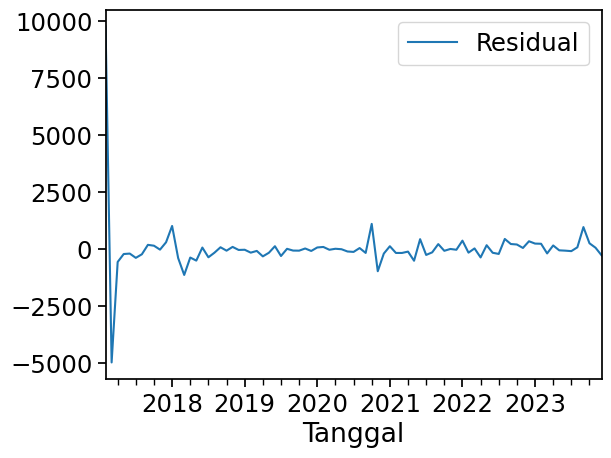

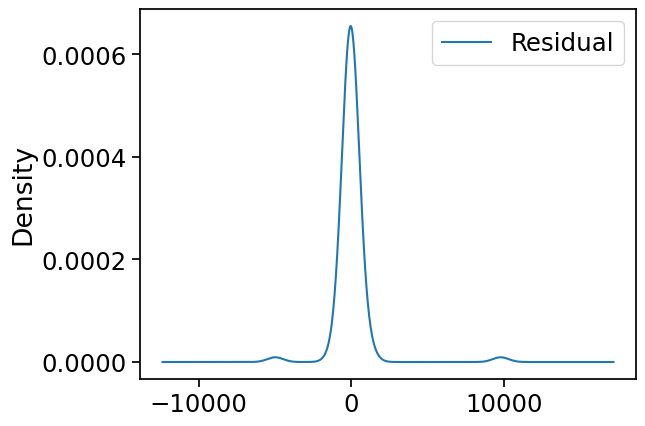

In [ ]:
# Store residual errors as variable
residuals = pd.DataFrame(model.resid).rename(columns={0: 'Residual'})

# Display statistical description of residuals
print(residuals.describe()) 

# Plot residual errors
residuals.plot()

# Plot residual errors with density
residuals.plot(kind='kde')

* Model bersifat *fit* terhadap data *time series* kita
* Performa baik karena residualnya mendekati 0 (*Gaussian*)

## Prediction

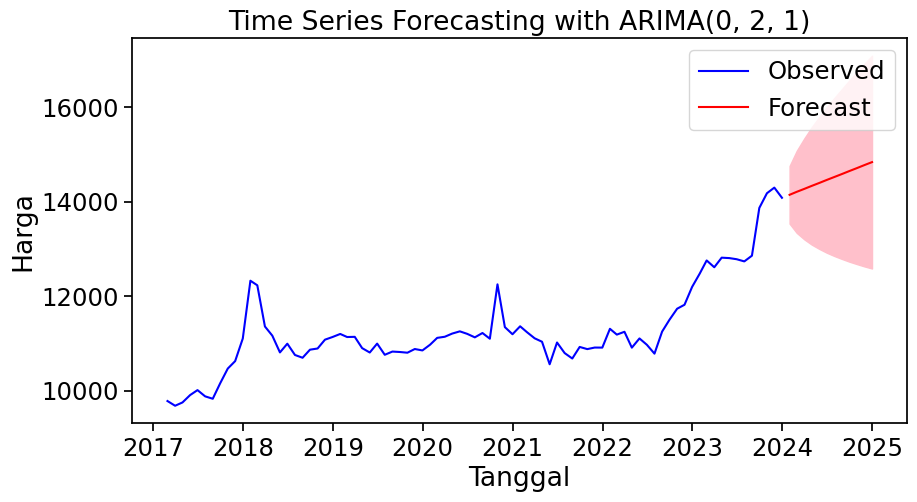

In [ ]:
# Generate prediction 12 next month
forecast_steps = 12  
forecast = model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Calculate upper and lower bound for each month
confidence_intervals = forecast.conf_int()

# Plot the original data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Harga'], label='Observed', color='blue')

# Plot the forecasted values
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Fill the area between the confidence intervals
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Harga'], confidence_intervals['upper Harga'], color='pink')

# Set title and axis label
plt.title('Time Series Forecasting with ARIMA(0, 2, 1)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')

# Show graph
plt.legend()
plt.show()